In this notebook we open the svg file and create the gcode but minimizing the reposition paths. 
This implementation is not the global optima, because we select se first object to transverse. 

In [35]:
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import re

from svgpathtools import svg2paths2, Path, Line, QuadraticBezier, CubicBezier, Arc
from py2gcode import py2gcode

#%%
paths, attributes,svg_attributes  = svg2paths2('data/radial_pattern.svg')

In [36]:
def tranverse_path(path,attribute,res = 0.4):
    """
    Transverse a given path for a given resolution
    
    Parameters
    ----------
    path : path to transverse
    attribute : dict with atributes (looking for transformations)
    res : step between points to resolve arcs or splines. The default is 0.8.

    Returns
    -------
    points : points in the path transvered

    """
    points = []
    z0 = 0 # translation stored in atributes
    if 'transform' in attribute:
        if 'translate' in attribute['transform']:
            values = re.findall(r"[-+]?(?:\d*\.*\d+)", attribute['transform'])
            z0 = complex(float(values[0]),float(values[1]))
            
    for seg in path._segments:
        if isinstance(seg,Line):
            points.append(seg.start+z0)
            points.append(seg.end+z0)
        else:
            n = round(seg.length(0,1)/res)
            if n != 0:
                ds = seg.length(0,1)/n
                for i in range(n):
                    t = seg.ilength(ds*i)
                    points.append(seg.point(t)+z0)
                points.append(seg.point(1)+z0)
    return np.array(points)

In [37]:
sorted_paths = [paths[0]]# new ordered list of paths
unsorted_paths = paths[1:]

#for path in paths:
#    print(path.start,path.end)
reverse = False
next_path = None
while len(sorted_paths)<len(paths):
    c_end = sorted_paths[-1].end
    d = np.inf
    for path in unsorted_paths:
        d1 = np.abs(path.start-c_end)
        d2 = np.abs(path.end-c_end)
        if d1<d:
            d = d1
            reverse = False
            next_path = path
            print(d)

        if d2<d:
            d = d2
            reverse = True
            next_path = path
            print(d)

    print(reverse)
    if reverse == True:
        
        sorted_paths.append(next_path.reversed())
    else:
        sorted_paths.append(next_path)
    unsorted_paths.remove(next_path)



119.32614914756417
55.63549864344974
27.327004228654474
22.722867383816208
True
40.93874407746287
37.65279795974032
4.659201105170825
4.491672518828594
1.8013094254805333
False
70.17098804730358
40.795239990085165
29.32389499426237
29.230720402947917
True
30.620236000000006
False
54.6117549204297
29.241309653303926
True
37.94267383778909
3.6387907496344196
1.8589705640383318
True
70.33228513372744
70.26755068550078
False
107.57102233624408
54.9993503168451
False
115.05776620820467
107.11395181601789
54.33113401358101
29.084826445858333
True
42.52459530216594
41.22792108944094
37.80572923665894
3.640697965606196
1.9605911707505521
False
97.78790799388881
70.43619451694765
41.09566347087227
29.34815545764339
29.278860692644127
True
56.7210092379321
30.819641819089593
30.690973999999997
False
107.33170098559087
85.27357077768586
74.11357825654487
False
70.1517353388309
40.92083555398257
29.38942389806961
True
30.614715963735637
False
72.80699073307422
29.24258645608444
True


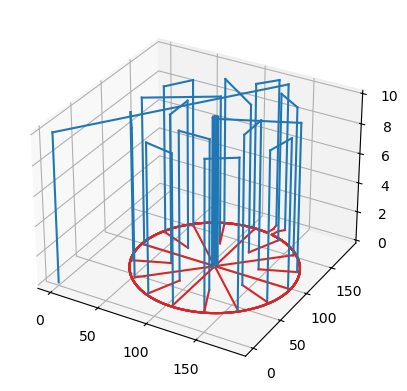

In [38]:
pgcode = py2gcode()
pgcode.go_home()
z_rep = 10.0
pgcode.move_abs(z = 10.0)
pgcode.line_diameter = 0.0
pgcode.feed = 100 # speed of movement, used or the working movements

for path,attribute in zip(sorted_paths,attributes):
    points = tranverse_path(path,attribute)
    p = points[0]
    pgcode.move_abs(x =np.real(p) ,y = np.imag(p))
    pgcode.move_abs(z = 0.0)
    for pi in points[1:]:
        pgcode.move_abs(x =np.real(pi) ,y = np.imag(pi),extrude= True) # we use this argument just to paint a change the movement speed
    pgcode.move_abs(z = 10.0)
pgcode.plot() # with a arbitrary aspect ratio
pgcode.out('tranversed_path_order') # export the with a given name